# Tarea 2

Integrantes:
* Juan Maulén 
* Pedro Pérez
* Tomás Rojas

In [1]:
from torchvision.datasets import DatasetFolder
import torch
import random
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler

In [2]:
def random_rotation(im, theta):
    theta = random.uniform(*theta)
    return im.rotate(theta)

def random_flip(im):
    if bool(random.getrandbits(1)):
        im.transpose(Image.FLIP_LEFT_RIGHT)
    return im
    
def normalize_im(im):
    im = np.asarray(im)
    
def loader(path):
    transformation = ToTensor()
    
    im = Image.open(path).resize((224, 224))  # escalamiento de la imagen
    im = random_flip(im)  # reflexion de la imagen
    im = random_rotation(im, (-20, 20))  # rotacion aleatoria de la imagen
    
    
    tensor = transformation(im)  # se transforma la imagen a un tensor
    if tensor.shape[0] == 1:
        tensor = tensor.repeat(3, 1, 1)
    
    rand_tensor = (1.5 - 1.2) * torch.rand((3, 224, 224)) + 1.2
    return tensor * rand_tensor


In [3]:
train_folder = DatasetFolder('./chest_xray/train', loader=loader, extensions='.jpeg')
# distribución real
test_folder = DatasetFolder('./chest_xray/test', loader=loader, extensions='.jpeg')

In [4]:
def histogram(train_folder, test_folder):
    train_folder_x, train_folder_y = np.unique(train_folder.targets, return_counts=True)
    test_folder_x, test_folder_y = np.unique(test_folder.targets, return_counts=True)
    plt.figure(figsize=(10,5))
    plt.bar(["'NORMAL' train","'PNEUMONIA' train"], 
            train_folder_y)
    plt.bar(["'NORMAL' test","'PNEUMONIA' test"], 
            test_folder_y)

    p_normal_train = train_folder_y[0] / train_folder_y.sum()
    p_pneumonia_train = train_folder_y[1] / train_folder_y.sum()
    p_normal_test = test_folder_y[0] / test_folder_y.sum()
    p_pneumonia_test = test_folder_y[1] / test_folder_y.sum()


    plt.text(-.1, train_folder_y[0] + 15,
             '{:.2f}%'.format(p_normal_train * 100))

    plt.text(-.1 + 1, train_folder_y[1] + 15,
             '{:.2f}%'.format(p_pneumonia_train * 100))

    plt.text(-.1 + 2, test_folder_y[0] + 15,
             '{:.2f}%'.format(p_normal_test * 100))

    plt.text(-.1 + 3, test_folder_y[1] + 15,
             '{:.2f}%'.format(p_pneumonia_test * 100))
    return

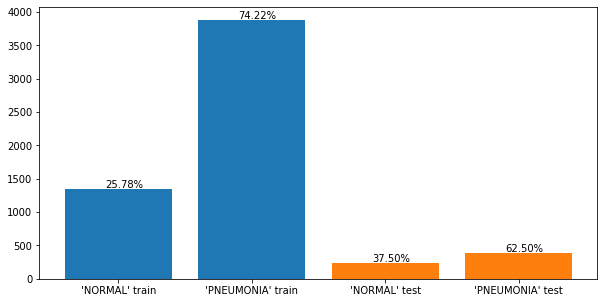

In [5]:
histogram(train_folder, test_folder)

In [6]:
# train test split
n_test =  int(len(train_folder) * .2)  
n_train = len(train_folder) - n_test
conjunto_train, conjunto_val = torch.utils.data.random_split(train_folder, [n_train, n_test])

In [7]:
class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        if len(etiquetas_val) != len(indices_val):
            etiquetas_val = np.array(etiquetas_val)[indices_val]
        self.etiquetas_prueba = np.array(etiquetas_prueba)
        self.indices_val = np.array(indices_val)
        self.etiquetas_val = np.array(etiquetas_val)
        
    def __iter__(self):
        # {'NORMAL': 0, 'PNEUMONIA': 1}
        clases_prueba, frecuencias_prueba = np.unique(self.etiquetas_prueba, 
                                                      return_counts=True)
        
        p_normal_deseada = frecuencias_prueba[0] / frecuencias_prueba.sum()
        
        indices_val_0 = self.indices_val[np.where(np.array(self.etiquetas_val)==0)]
        indices_val_1 = self.indices_val[np.where(np.array(self.etiquetas_val)==1)]
        
        n_1 = len(indices_val_1)
        n_0 = int(n_1 *p_normal_deseada/(1 - p_normal_deseada))
        
        indices_val_0 = np.random.choice(indices_val_0, n_0)
        
        lista_con_indices = indices_val_0.tolist() + indices_val_1.tolist()
        return iter(lista_con_indices)

In [8]:
val_sampler = ReplicarMuestreoDePrueba(test_folder.targets, 
                                        conjunto_val.indices, 
                                        conjunto_val.dataset.targets)
bs = 4
training_sampler = SubsetRandomSampler(conjunto_train.indices)
test_sampler = RandomSampler(range(len(test_folder)))
train_dl = DataLoader(train_folder, batch_size = bs, sampler = training_sampler)
validation_dl = DataLoader(train_folder, batch_size = bs, sampler = val_sampler)
test_dl = DataLoader(test_folder, batch_size = bs, sampler = test_sampler)

In [9]:
# P2

In [10]:
import torch

torch.manual_seed(4020)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class DWSepConv2d(nn.Module):
    
    def __init__(self,  in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, padding, bias = bias)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = bias)
        
    def forward(self, x):
        xb = self.conv1(x)
        xb = F.relu(self.conv2(xb))
        return xb

In [12]:
class VGG16DWSep(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1layer1=nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.conv1layer2=nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.maxpool2d1=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2layer1=DWSepConv2d(64,128,3,1)
        self.conv2layer2=DWSepConv2d(128,128,3,1)
        self.maxpool2d2=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv1=DWSepConv2d(128,256,3,1)
        self.batchnorm1=nn.BatchNorm2d(256)
        
        self.conv2=DWSepConv2d(256,256,3,1)
        self.batchnorm2=nn.BatchNorm2d(256)
        
        self.conv3=DWSepConv2d(256,512,3,1)
        self.maxpool2d3=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4=DWSepConv2d(512,512,3,1)
        self.batchnorm4=nn.BatchNorm2d(512)
        
        self.conv5=DWSepConv2d(512,512,3,1)
        self.batchnorm5=nn.BatchNorm2d(512)
        
        self.conv6=DWSepConv2d(512,512,3,1)
        self.maxpool2d6=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.flatten=nn.Flatten()
        
        self.fc1 = nn.Linear(512*81, 1024)
        self.dropout1=nn.Dropout(.7)
        
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2=nn.Dropout(.5)
        
        self.fc3 = nn.Linear(512, 2)
    
       
    def forward(self,xb):
        xb = xb.view(-1,3,224,224)
        xb = F.relu(self.conv1layer1(xb))
        xb = F.relu(self.conv1layer2(xb))
        xb = F.relu(self.maxpool2d1(xb))
        
        xb = F.relu(self.conv2layer1(xb))
        xb = F.relu(self.conv2layer2(xb))
        xb = F.relu(self.maxpool2d2(xb))
        
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.batchnorm1(xb))
        
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.batchnorm2(xb))
        
        xb = F.relu(self.conv3(xb))
        xb = F.relu(self.maxpool2d3(xb))
        
        xb = F.relu(self.conv4(xb))
        xb = F.relu(self.batchnorm4(xb))
        
        xb = F.relu(self.conv5(xb))
        xb = F.relu(self.batchnorm5(xb))
        
        xb = F.relu(self.conv6(xb))
        xb = F.relu(self.maxpool2d6(xb))
        
        xb = F.relu(self.flatten(xb))
        
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.dropout1(xb))
        
        xb = F.relu(self.fc2(xb))
        xb = F.relu(self.dropout2(xb))
        
        xb = F.relu(self.fc3(xb))
        
        return xb.view(-1, xb.size(1))

In [13]:
#Capas preentrenadas
import torchvision
from torchvision import models


model_VGG16 = torchvision.models.vgg16(pretrained=True, progress=True)
pesos_capa1 = model_VGG16.features[0].weight
pesos_capa2 = model_VGG16.features[2].weight
pesos_capa1.requires_grad = False
pesos_capa2.requires_grad = False

In [14]:
class VGG16DWSep(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1layer1=nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.conv1layer1.weight = pesos_capa1
        self.conv1layer2=nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.conv1layer2.weight = pesos_capa2
        self.maxpool2d1=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2layer1=DWSepConv2d(64,128,3,1)
        self.conv2layer2=DWSepConv2d(128,128,3,1)
        self.maxpool2d2=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv1=DWSepConv2d(128,256,3,1)
        self.batchnorm1=nn.BatchNorm2d(256)
        
        self.conv2=DWSepConv2d(256,256,3,1)
        self.batchnorm2=nn.BatchNorm2d(256)
        
        self.conv3=DWSepConv2d(256,512,3,1)
        self.maxpool2d3=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4=DWSepConv2d(512,512,3,1)
        self.batchnorm4=nn.BatchNorm2d(512)
        
        self.conv5=DWSepConv2d(512,512,3,1)
        self.batchnorm5=nn.BatchNorm2d(512)
        
        self.conv6=DWSepConv2d(512,512,3,1)
        self.maxpool2d6=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.flatten=nn.Flatten()
        
        self.fc1 = nn.Linear(512*81, 1024)
        self.dropout1=nn.Dropout(.7)
        
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2=nn.Dropout(.5)
        
        self.fc3 = nn.Linear(512, 2)
    
       
    def forward(self,xb):
        xb = xb.view(-1,3,224,224)
        xb = F.relu(self.conv1layer1(xb))
        xb = F.relu(self.conv1layer2(xb))
        xb = F.relu(self.maxpool2d1(xb))
        
        xb = F.relu(self.conv2layer1(xb))
        xb = F.relu(self.conv2layer2(xb))
        xb = F.relu(self.maxpool2d2(xb))
        
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.batchnorm1(xb))
        
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.batchnorm2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.relu(self.maxpool2d3(xb))
        
        xb = F.relu(self.conv4(xb))
        xb = F.relu(self.batchnorm4(xb))
        
        xb = F.relu(self.conv5(xb))
        xb = F.relu(self.batchnorm5(xb))
        
        xb = F.relu(self.conv6(xb))
        xb = F.relu(self.maxpool2d6(xb))
        
        xb = F.relu(self.flatten(xb))
        
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.dropout1(xb))
        
        xb = F.relu(self.fc2(xb))
        xb = F.relu(self.dropout2(xb))
        
        xb = F.relu(self.fc3(xb))
        
        return xb.view(-1, xb.size(1))

In [15]:
class EarlyStopping():
    
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        self.modo = modo
        self.wait = paciencia
        self.perc = porcentaje
        self.tol = tol
        self.best = None
        self.bestep = 0
    
    def mejor(self, metrica_validacion):
        
        '''
        Retorna True cuando se mejora el mejor valor obtenido en métrica. 
        En caso contrario retorna False.
        '''
        
        if self.best == None:
            self.best = metrica_validacion
            return True
        if self.perc == False:
            if self.modo == 'min':
                if metrica_validacion < self.best - self.tol:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
            else:
                if metrica_validacion > self.best + self.tol:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
        else: 
            if self.modo == 'min':
                if metrica_validacion < (1-self.tol)*self.best:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
            else:
                if metrica_validacion > (1+self.tol)*self.best:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
        
    
    def deberia_parar(self, metrica_validacion):
        comp = self.mejor(metrica_validacion)
        if not comp and self.bestep == self.wait:
            return True
        else:
            return False
                 

In [16]:
torch.cuda.is_available()

True

In [17]:
torch.device("cuda") 

device(type='cuda')

In [18]:
#Ciclo de entrenamiento
from torch import optim
from sklearn.metrics import f1_score

f1 = []
acurracy = []
losses = []
model = VGG16DWSep()
model.cuda()
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = F.cross_entropy
num_epoch = 20
es  = EarlyStopping(modo = 'max')
for epoch in range(num_epoch):
    #ciclo de entrenamiento
    for i, (images, labels) in enumerate(train_dl):
        
        outputs = model(images.cuda())
        loss = loss_func(outputs.cuda(), labels.long().cuda())
        losses.append(loss.item())

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    #ciclo de validación
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(validation_dl):
        outputs = model(images.cuda()) 
        correct += (torch.argmax(outputs, dim=1) == labels.cuda()).float().sum() 
        total += len(labels)
    
    metrica_validacion_1 = 100 * correct / total #acurracy
    metrica_validacion_1 = metrica_validacion_1.item()
    #metrica_validacion_2 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
    if (epoch+1) % 2 == 0:
        print('Epoca:', epoch+1,',', 'metrica:', metrica_validacion_1)
    acurracy.append(metrica_validacion_1)
    #f1.append(metrica_validacion_2)
    if es.deberia_parar(metrica_validacion_1):
        break
    

In [23]:
acurracy

[80.9864730834961,
 84.32776641845703,
 79.15672302246094,
 90.0556869506836,
 89.3396987915039,
 90.45346069335938,
 89.89657592773438,
 88.7828140258789,
 90.6125717163086,
 90.85123443603516,
 87.27127838134766,
 89.65791320800781,
 92.5218734741211,
 93.87430572509766,
 92.84009552001953,
 91.40811157226562,
 93.23786926269531,
 91.08989715576172,
 93.23786926269531]

In [40]:
#ciclo de testeo del modelo
for i, (images, labels) in enumerate(test_dl):
    outputs = model(images.cuda()) 
    correct += (torch.argmax(outputs, dim=1) == labels.cuda()).float().sum() 
    total += len(labels)
    valor = 100 * correct / total #acurracy
    valor = valor.item()
valor

87.8787841796875

In [37]:
import pickle

f = open('tarea2_model', 'wb')
pickle.dump(model, f)
f.close()

In [19]:
#P3